In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

from aux import zscore
from disp import set_plot

cc = np.concatenate

FPS = 30.03
DT = 1/FPS

NR = 224  # original number of responses
NTR = 276  # number of trials

PCA_FILE = 'data/simple/mlv_c/neur_basic/c_baker_dyn_pca/pca_results.npy'
DYN_FIT_FILE = 'data'

In [2]:
# neural response fits from Baker data
df_dyn_param = pd.read_csv('data/simple/baker_dyn_fit_param.csv')
df_dyn_param

,EXPT_ID,LINE,FLY,ROI,ROI_USED,FIT_ERR,SUCCESS,T_0,R_0,TAU_R,TAU_A,X_S,X_P
0,0,R70G01,0,somas,False,0.275200,True,-0.000000,0.028882,6.202615,30.336758,-4.958290,-2.597432
1,1,R70G01,1,somas,False,0.186212,True,0.117647,0.025128,3.835468,21.821295,-4.163967,-1.472075
2,2,R70G01,2,somas,False,0.248414,True,-0.000000,0.055962,6.017162,15.058055,-6.248007,-2.095952
3,3,R70G01,3,somas,False,0.455963,True,-0.000000,-0.014227,6.016828,11.820576,-5.679735,-2.118245
4,4,R70G01,4,somas,False,0.229018,True,-0.000000,0.019831,6.434825,55.496220,-4.415761,-2.863647
...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,219,VT34811,0,somas,False,0.276087,True,-0.000000,0.039119,1.799608,1440.994269,-0.049828,2.494657
220,220,VT34811,0,ascending projection,False,0.037801,True,-0.000000,-0.001886,1.298841,27.643238,0.098451,2.457383
221,221,vPN1_split,0,somas,False,0.404112,True,-0.588235,-0.014702,4.151226,6.155551,8.332263,2.353217
222,222,vPN1_split,1,somas,False,1.205977,True,0.235294,-0.095665,5.924070,90.705238,2.390705,0.604586


In [3]:
expt_ids = df_dyn_param['EXPT_ID']

# get parameters
tau_rs = np.array(df_dyn_param['TAU_R'])
tau_as = np.array(df_dyn_param['TAU_A'])
x_ss = np.array(df_dyn_param['X_S'])
x_ps = np.array(df_dyn_param['X_P'])

In [4]:
# define smln & obj function
def smlt_ppln(i_s, i_p, tau_r, tau_a, x_s, x_p):
    """Simulate response to song inputs."""
    n = len(tau_r)
    t = np.arange(len(i_s))*DT
    rs = np.nan*np.zeros((len(t), n))
    
    rs[0, :] = 0
    a_s, a_p = 0, 0
    
    for ct, t_ in enumerate(t[1:], 1):
        a_s += ((DT/tau_a) * (-a_s + x_s*i_s[ct]))
        a_p += ((DT/tau_a) * (-a_p + x_p*i_p[ct]))
        rs[ct, :] = rs[ct-1, :] + (DT/tau_r) * (-rs[ct-1, :] + (x_s - a_s)*i_s[ct] + (x_p - a_p)*i_p[ct])
    
    return rs

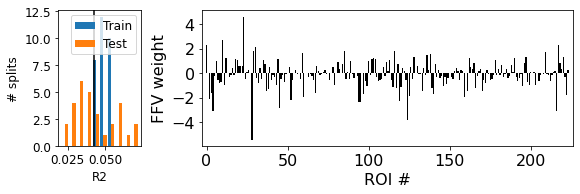

In [102]:
# mean regressor from lin fit from dyn neurons
DYN_FFV_FIT_FILE = 'data/simple/mlv_c/neur_basic/c_baker_ridge_0.1_dyn_all_ffv_276_tr.npy'
# DYN_FFV_FIT_FILE = 'data/simple/mlv_c/neur_basic/c_baker_dyn_all_ffv_276_tr.npy'
dyn_fit_data = np.load(DYN_FFV_FIT_FILE, allow_pickle=True)[0]

r2_train = dyn_fit_data['r2_train']
r2_test = dyn_fit_data['r2_test']

w_mn = dyn_fit_data['w'].mean(axis=0)
w_sd = dyn_fit_data['w'].std(axis=0)

gs = gridspec.GridSpec(1, 4)
fig = plt.figure(figsize=(8, 2.75), tight_layout=True)
axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1:])]
axs[0].hist(np.array([r2_train, r2_test]).T)
axs[0].legend(['Train', 'Test'])
axs[0].axvline(r2_test.mean(), c='k')
set_plot(axs[0], x_label='R2', y_label='# splits', font_size=12)

axs[1].bar(range(NR), w_mn, color='k')
set_plot(axs[1], x_lim=[-3, NR+2], x_label='ROI #', y_label='FFV weight', font_size=16)

# Search bouts that maximize projection along negative FFV axis

In [6]:
def get_ffv_prj(bt):
    i_s = (bt == 1).astype(float)
    i_p = (bt == 2).astype(float)
    
    return smlt_ppln(i_s, i_p, tau_rs, tau_as, x_ss, x_ps) @ w_mn

def get_ffv_prj_mn(bt):
    return np.mean(get_ffv_prj(bt))

Search over structured bouts

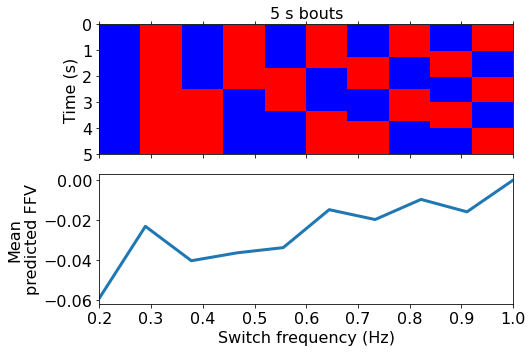

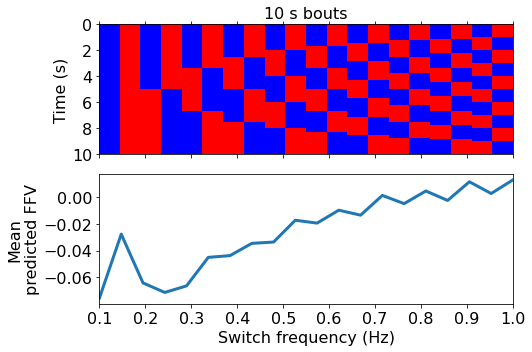

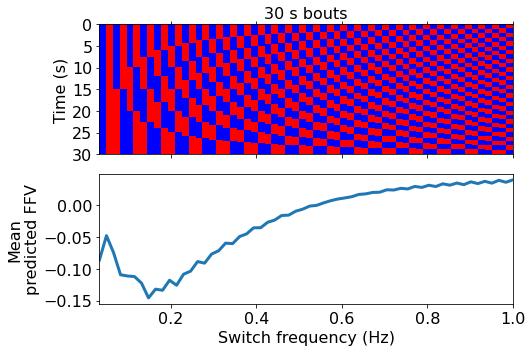

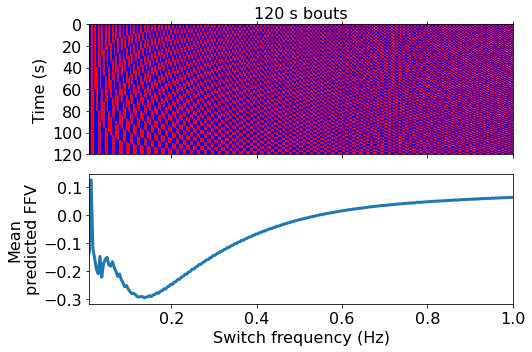

In [86]:
for dur in [5, 10, 30, 120]:
    bts = []
    scores = []
    periods = []
    
    for nswitch in np.arange(0, dur):
        t = np.arange(0, dur, 1/30.03)
        period = 2*dur/(nswitch+1)

        bt = np.zeros(len(t))
        bt[np.sin(2*np.pi*t/period) > 0] = 1
        bt[np.sin(2*np.pi*t/period) < 0] = 2

        bts.append(bt)
        scores.append(get_ffv_prj_mn(bt))

        bt = np.zeros(len(t))
        bt[np.sin(2*np.pi*t/period) > 0] = 2
        bt[np.sin(2*np.pi*t/period) < 0] = 1

        bts.append(bt)
        scores.append(get_ffv_prj_mn(bt))
        
        periods.extend(2*[period])

    bts = np.array(bts)
    scores = np.array(scores)
    periods = np.array(periods)
    
    switch_freq = np.linspace(2/periods[0], 2/periods[-1], len(bts))
    
    colors = [(.7, .7, .7), (0, 0, 1), (1, 0, 0)]
    cmap = LinearSegmentedColormap.from_list('song_modes', colors, N=3)
    fig, axs = plt.subplots(2, 1, figsize=(7.5, 5), tight_layout=True, sharex=True)
    axs[0].matshow(bts.T, extent=[switch_freq[0], switch_freq[-1], dur, 0], vmin=0, vmax=2, cmap=cmap)
    axs[0].set_aspect('auto')
    set_plot(axs[0], y_label='Time (s)', title=f'{dur} s bouts', font_size=16)
    axs[1].plot(switch_freq, scores, lw=3)
    set_plot(axs[1], x_label='Switch frequency (Hz)', y_label='Mean\npredicted FFV')

    for ax in axs:
        set_plot(ax, font_size=16)